# 課題8 線形回帰

配点
- Q1.1 1P
- Q1.2 1P
- Q1.3 2P
- Q1.4 1P
- Q2 2P
- Q3 3P

In [1]:
# モジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Q1.1 特徴間の相関係数

irisデータセットの特徴量`petal_length`と`petal_width`の関係を散布図で可視化すると以下のように2つの特徴量間に関係があることがわかります。

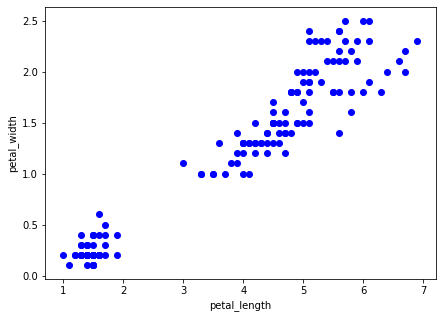

In [2]:
iris = pd.read_csv('iris.csv')

plt.figure(figsize=(7,5))
plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.scatter(iris['petal_length'], iris['petal_width'], c='blue');

In [3]:
### scikit-learnからデータロードする場合
# from sklearn.datasets import load_iris
# iris = load_iris()
#plt.figure(figsize=(7,5))
#plt.xlabel(iris["feature_names"][2])
#plt.ylabel(iris["feature_names"][3])
#plt.scatter(iris['data'][:,2],iris['data'][:,3],c='blue');

irisデータセットの特徴量`petal_length`と`petal_width`のデータを`NumPy`の1次元配列として受け取って、それらの相関係数を返す以下の関数`petal_corr()`を完成させてください。

In [4]:
def petal_corr(length, width):
    return np.corrcoef(length, width)[-1][0]### 1次元配列lengthと1次元配列widthの相関係数を計算するコード ###

関数`petal_corr()`が完成したら以下のセルを実行して動作を確認してください。以下では`pandas`シリーズオブジェクトの`values`属性を用いて特徴量データを`NumPy`の配列にして関数`petal_corr()`の引数に渡しています。相関係数は$\simeq0.96$となります。

In [5]:
petal_corr(iris['petal_length'].values, iris['petal_width'].values)

0.9627570970509663

## Q1.2 特徴量の標準化

以下では、線形回帰により特徴量`petal_length`から特徴量`petal_width`を予測するような仮説関数のパラメータを学習することを考えます。

まず準備として、特徴量`petal_length`を入力$X$、特徴量`petal_length`を出力$y$としてそれぞれを標準化します。

`NumPy`の任意の行数、列数の2次元配列を受け取り、各要素の値をその列の平均値と標準偏差を用いて標準化した配列を返す`normalizer()`関数を完成させてください。

In [6]:
#偏差 = 各個人の点数　-　平均点ave
#分散 = 偏差の2乗の合計　÷　人数len(mat)
#標準偏差 = 分散のルートの値
#標準化 = (元のデータ - 平均値ave)/標準偏差

In [7]:
def normalizer(mat):
    ave = np.mean(mat) 
    std = np.std(mat) 
    
    for i in range(len(mat)):
        mat[i] = (mat[i]-ave)/std
    return mat
        
    #return np.std(mat, axis=0)### 配列matを列ごとに標準化した配列を計算するコード ###

関数`normalizer()`が完成したら以下のセルを実行して動作を確認してください。標準化された入力$X_{norm}$、標準化された出力$y_{norm}$の要素の和はそれぞれ$\simeq 4.9e^{-14} $, $\simeq-4.2e^{-14}$となります。（評価はコードを見て行うので必ずしも一致していなくとも構いません）

In [8]:
iris = pd.read_csv('iris.csv')
X=iris[['petal_length']].values # 入力X
y=iris[['petal_width']].values # 出力y

### scikit-learnからデータロードした場合 
# X=(iris['data'][:,2])[:,np.newaxis] # 列ベクトルにする
# y=(iris['data'][:,3])[:,np.newaxis] # 列ベクトルにする

X_norm = normalizer(X) # 入力の標準化
y_norm = normalizer(y) # 出力の標準化

print(X_norm.sum())
print(y_norm.sum())

4.973799150320701e-14
-4.263256414560601e-14


次に、入力の各データにバイアス項($x_0=1$)を追加するため、入力の先頭列に1を要素とする列ベクトルを挿入します。これにより、入力,　出力はデータ数を$m$として以下のような行列（$m \times 2$) とベクトル($m \times 1$)になります。

$
  X = \left(
    \begin{array}{cc}
      1 &   x^{(1)} \\
      1 &   x^{(2)}  \\
      ... & ... \\
      1 &  x^{(m)}
    \end{array}
  \right)
$

$x^{(i)}$は標準化された特徴量petal_length。

$
  y = \left(
    \begin{array}{c}
       y^{(1)}  \\
      ...\\
        y^{(m)}  \\
    \end{array}
  \right)
$

$y^{(i)}$は標準化された特徴量petal_width。

In [9]:
X_norm=np.insert(X_norm, 0, np.ones((1,X.shape[0]), dtype=int), axis=1) # バイアス項の追加

#print(X_norm)
#print(X_norm[:10,:])
print(y_norm[:10])
print(y_norm[0])

[[-1.31297673]
 [-1.31297673]
 [-1.31297673]
 [-1.31297673]
 [-1.31297673]
 [-1.05003079]
 [-1.18150376]
 [-1.31297673]
 [-1.31297673]
 [-1.4444497 ]]
[-1.31297673]


## Q1.3 最急降下法

以下では、最急降下法により、訓練データセットを元に入力から出力を予測する仮説関数のパラメータを学習する`graddes`関数を実装します。

`graddes`関数では第1引数に入力のデータ行列（データ数($m$)$\times$(特徴量数+バイアス)($n$))、第2引数に入力の各データに対する出力（正解）のベクトル（$m\times1$）、第3引数に学習率、第4引数に学習の繰り返し（各繰り返しをエポックと呼ぶ）の回数を受け取ります。

これらの引数を元に、`graddes`関数ではパラメータの学習を行い、以下を返します
- エポックごとのコスト関数の値を要素とするリスト
- 最終的なパラメータの値を要素とする配列（$n\times1$）を返します。



パラメータを$\theta=(\theta_0, \theta_1, ..., \theta_{n-1})^T$

仮説関数を$h(x)=\theta_0+\theta_1x_1+\theta_2x_2+....+\theta_{n-1}x_{n-1}$

入力を$
  X = \left(
    \begin{array}{cccc}
      x_0^{(1)} &   x_1^{(1)} & ... &   x_{n-1}^{(1)}  \\
      ... & ...& ...&...\\
      x_0^{(m)} &  x_1^{(m)} & ... &   x_{n-1}^{(m)}  \\
    \end{array}
  \right)
$ 

$X$において$x_0^{(i)}=1$

出力を$y=(y^{(1)}, y^{(2)}, ..., y^{(m)})^T$

とすると、最急降下法ではコスト関数を

$J(\theta)=\frac{1}{2m}\Sigma_{i=1}^m (h(x^{(i)})-y^{(i)})^2$

として、入力$X$の各特徴量$x_j$に対するパラメータ$\theta_j$を以下の様に更新していきます。

$\theta_j:= \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j} =  \theta_j - \frac{\alpha}{m} \Sigma_{i=1}^m ((h(x^{(i)})-y^{(i)})x^{(i)}_j)$

パラメータ全体を以下のように一度に更新することもできます。

$\theta := \theta - \frac{\alpha}{m}X^T(X\theta-y)$

入力が1特徴量（変数）の時は、バイアス項に対するパラメータを$\theta_0$、入力変数に対するパラメータを$\theta_1$としてパラメータは以下の様に更新されます。

$\theta_0 := \theta_0 - \alpha  \Sigma_{i=1}^m (h(x^{(i)})-y^{(i)})/m$ 

$\theta_1 := \theta_1 - \alpha  \Sigma_{i=1}^m ((h(x^{(i)})-y^{(i)})x^{(i)})/m$

具体的に、`graddes`関数では以下の手順によりパラメータの学習を行います。

- 引数`n_iter`で指定されたエポックの回数だけ以下を繰り返す    

     - すべてのm個のデータについて以下を求める
        
        - 入力データ$x^{(i)}$について仮説関数$h(x^{(i)})$の値を求める
        
        - 出力$y^{(i)}$との誤差$h(x^{(i)})-y^{(i)}$の値を求める
    
     - すべてのm個のデータの誤差を用いてコスト関数$J(\theta)$の値を求め、各エポックのコスト関数の値を要素とするリスト`costs`に追加
 
     - すべてのm個のデータの誤差を用いて各パラメータ$\theta_j(j=0,..,n-1)$を更新し、パラメータの値を要素とする配列`w`を更新
          - `w[0,0]`$:=$($x_0$に対するパラメータ$\theta_0$), 
          - ...,
          - `w[n-1,0]`$:=$($x_{n-1}$に対するパラメータ$\theta_{n-1}$)
          
 すべての繰り返しが終了したらリスト`costs`と配列`w`を返す。
 
 上記に従って、`graddes`関数を完成させてください。

In [10]:
w = np.zeros((5,1))
print(w)

A = np.arange(-3.0, 3.0, 0.1)
print(A)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[-3.00000000e+00 -2.90000000e+00 -2.80000000e+00 -2.70000000e+00
 -2.60000000e+00 -2.50000000e+00 -2.40000000e+00 -2.30000000e+00
 -2.20000000e+00 -2.10000000e+00 -2.00000000e+00 -1.90000000e+00
 -1.80000000e+00 -1.70000000e+00 -1.60000000e+00 -1.50000000e+00
 -1.40000000e+00 -1.30000000e+00 -1.20000000e+00 -1.10000000e+00
 -1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01  2.66453526e-15  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e+00  1.10000000e+00  1.20000000e+00  1.30000000e+00
  1.40000000e+00  1.50000000e+00  1.60000000e+00  1.70000000e+00
  1.80000000e+00  1.90000000e+00  2.00000000e+00  2.10000000e+00
  2.20000000e+00  2.30000000e+00  2.40000000e+00  2.50000000e+00
  2.60000000e+00  2.70000000e+00  2.80000000e+00  2.9000000

In [11]:
z = np.zeros((1,5))
type(z)
#ndarray インスタンスは、numpy.array 関数で生成することができます。 

numpy.ndarray

In [12]:
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 5]])#4行3列
b = np.array([1, 2, 3])#1行3列
c = np.array([3, 4, 6, 8])
print(a*b)
print(2*a*b)
print(a-b)
print(a.dot(b))#1行4列
print(a.T)
print(a.T.dot(c))

[[ 1  4  9]
 [ 4 10 18]
 [ 7 16 27]
 [ 1  4 15]]
[[ 2  8 18]
 [ 8 20 36]
 [14 32 54]
 [ 2  8 30]]
[[0 0 0]
 [3 3 3]
 [6 6 6]
 [0 0 2]]
[14 32 50 20]
[[1 4 7 1]
 [2 5 8 2]
 [3 6 9 5]]
[ 69  90 127]


In [13]:
def graddes(X, y, alpha, n_iter): #Xはnp.array #yもnp.array #alpha学習率、n_iterエポック数
    m = X.shape[0] # データ数
    n =  X.shape[1] # 次元（特徴量+バイアス）数
    
    costs=[] # エポックごとのコスト関数の値を入れるリスト #要素数n_iter
    w = np.zeros((n,1)) #各特徴量に対するパラメータ（重み）の初期化 #θ #1列のリストのn行リスト(n行1列)
    for l in range(n_iter):
        
        error = [] #要素数m
        for i in range(m):
            hypo_function = 0
            for j in range(n):
                hypo_function += w[j][0]*X[i][j]### コスト関数の計算とパラメータの更新をするコード ###
            error.append(hypo_function - y[i][0])# graddes関数は任意の次元数の入力Xを想定していますが、この一般的な実装が難しければ

        error_error = 0
        for i in range(m):
            error_error += error[i]**2
        costs.append(error_error/(2*m))
        
        
        w = w - (alpha / m * X.T.dot(X.dot(w) - y))
                # まずは上記の定義に従って以下のように1変数+バイアス項の入力（対応するパラメータは2つ）で動くものを実装してもらっても構いません
                    # すべてのm個のデータの誤差(h(x)-y)を求める
                    # コスト関数Jを計算
                    #　costsにコスト関数の値を追加
                    # パラメータθ_0とθ_1を計算
                    # w[0,0]=更新されたパラメータθ_0,
                    # w[1,0]=更新されたパラメータθ_1

                # パラメータ更新ではデータ数についてのfor文とパラメータ数のfor文を回して更新していくことが考えられますが
                # 上記のパラメータ全体を更新する行列・ベクトル演算でこれらのfor文なしにパラメータを更新できます。
                # numpyに慣れている人はこちらの方針で実装してもらって構いません
        
    return costs, w

## Q1.4 最急降下法によるパラメータ推定
`graddes`関数が完成したら以下のセルを実行して動作を確認してください。上記のirisデータセットの特徴量`petal_length`を入力、特徴量`petal_length`を出力とした訓練データセットを与え、学習率を0.05、学習のエポック数を100とした時の各エポックごとのコスト関数の値を示しています。パラメータの学習が進むにつれてコスト関数の値が減少していくことがわかります。

この時の最終的なコスト関数の値は$\simeq 0.036$、パラメータ$\theta_0, \theta_1$の値はそれぞれ約$\simeq -3.6e^{-16}$, $\simeq 9.5e^{-1}$となります。（評価はコードを見て行うので必ずしも一致していなくとも構いません）

**学習率$\alpha$を$0.01$, $0.1$と変更して、その時のコスト関数の曲線と100エポックでのコスト関数の値をそれぞれ観察してください。**それぞれ100エポックで十分にパラメータの推定がされたといえるでしょうか。

In [40]:

X = np.array([[2, 4, 3], [3, 4, 5], [1, 3, 5], [6, 7 ,8]]) #m=4, n=3
y = np.array([[3], [5], [2], [7]]) #m=4
Z = np.array([[2, 4, 3], [3, 4, 5], [1, 3, 5]])
n_iter=100 #エポック数
alpha=0.05
m = X.shape[0]
n = X.shape[1]
w = np.zeros((n,1))
#X.dot(w)#4行1列
#X.transpose() == X.T #true
np.dot(X.T,X)
#X*X
w = w - (alpha / m * np.dot(X.T, (np.dot(X, w) - y)))
print(w)
#print(graddes(X, y, alpha, n_iter)[0]) #costs
#print(graddes(X, y, alpha, n_iter)[1]) #w
#print(graddes(X, y, alpha, n_iter)[2]) #error


[[0.8125]
 [1.0875]
 [1.25  ]]


0.0365673862381051
[[-3.72017232e-16]
 [ 9.57057066e-01]]


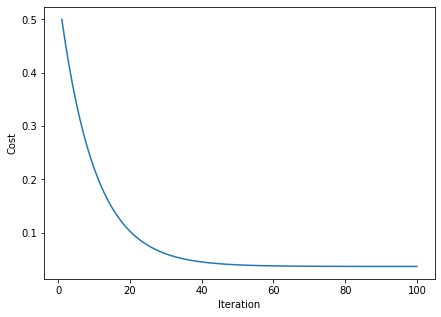

In [15]:
n_iter=100 #エポック数
alpha=0.05 #学習率
costs, w = graddes(X_norm, y_norm, alpha, n_iter)
print(costs[-1]) # 100エポックでのコスト関数の値(リストの最後の値)
print(w) # 推定されたパラメータ

plt.figure(figsize=(7,5))
plt.ylabel('Cost')
plt.xlabel('Iteration');
plt.plot(range(1,n_iter+1),costs);

100回のエポックで学習されたパラメータ$\theta_0, \theta_1$を用いて特徴量`petal_length`を入力$x$、特徴量`petal_length`を出力$y$とした時の直線$y=\theta_0+\theta_1x$は以下のようになります。

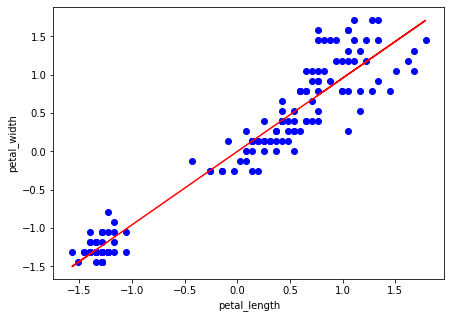

In [16]:
# 回帰直線のプロット
def lineplot(X,y,w):
    plt.figure(figsize=(7,5))
    plt.xlabel('petal_length')
    plt.ylabel('petal_width')
    plt.scatter(X[:,1],y[:,0],c='blue')
    plt.plot(X[:,1], np.dot(X,w)[:,0], color='red');

lineplot(X_norm, y_norm, w)

コスト関数$J(\theta)$とパラメータ$\theta_0, \theta_1$は以下のようになります。

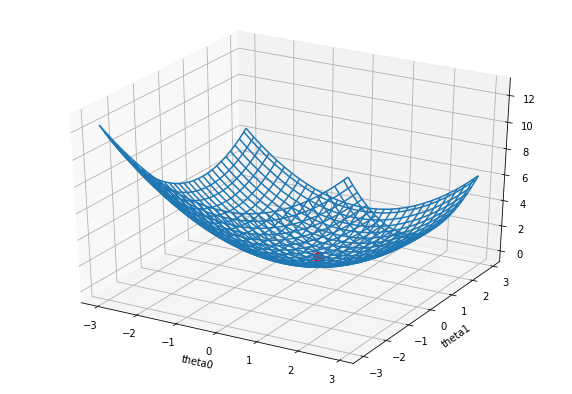

In [17]:
from mpl_toolkits.mplot3d import Axes3D

# コスト関数のプロット
def costplot(X, y, w, cost):
    w0, w1 = np.meshgrid(np.arange(-3.0, 3.0, 0.1), np.arange(-3.0, 3.0, 0.1))
    J=np.zeros(w0.shape)
    for i in range(w0.shape[0]):
        for j in range(w0.shape[1]):
            J[i,j] = np.sum((np.dot(X, np.array([[w0[i,j]],[w1[i,j]]]))-y)**2)/(2*X.shape[0])
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel("theta0")
    ax.set_ylabel("theta1")
    ax.scatter(w[0,0], w[1,0], cost, s=100, c='red')
    ax.plot_wireframe(w0, w1, J);

costplot(X_norm, y_norm, w, costs[-1] )

一方、5回、20回のエポックで学習されたパラメータを用いた時の直線はそれぞれ以下のようになります。エポックが進むにつれて、訓練データセットにフィッティングするようにパラメータが学習されていることがわかります。

0.3440119922341869
[[3.46019509e-17]
 [2.17794008e-01]]


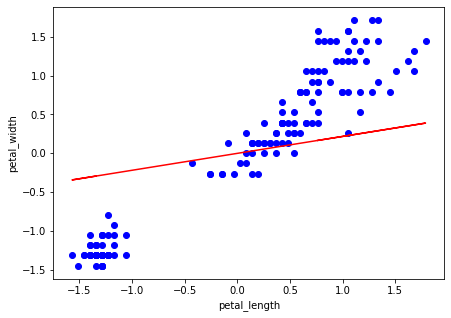

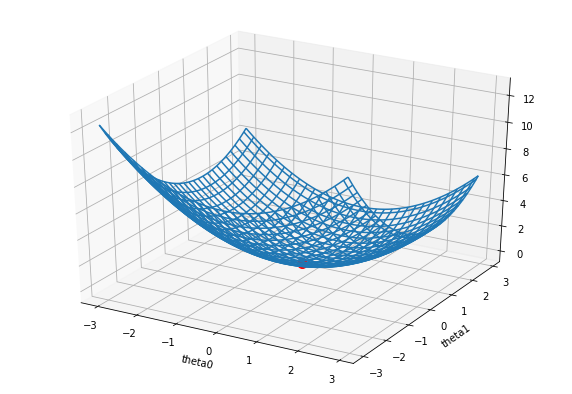

In [18]:
n_iter=5
alpha=0.05
costs, w = graddes(X_norm, y_norm, alpha, n_iter)
print(costs[-1])
print(w)

lineplot(X_norm, y_norm, w)
costplot(X_norm, y_norm, w, costs[-1] )

0.10254277979140758
[[-1.46938017e-16]
 [ 6.17622231e-01]]


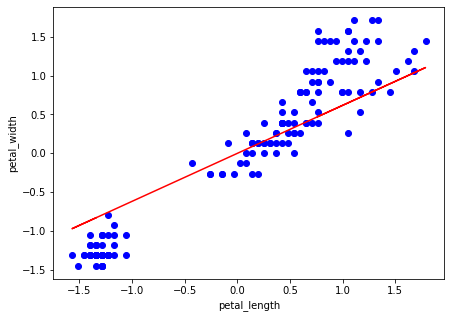

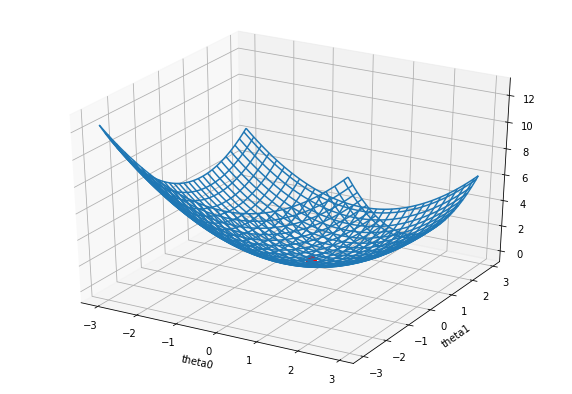

In [19]:
n_iter=20
alpha=0.05
costs, w = graddes(X_norm, y_norm, alpha, n_iter)
print(costs[-1])
print(w)

lineplot(X_norm, y_norm, w)
costplot(X_norm, y_norm, w, costs[-1] )

## Q2 正規方程式
線形回帰のパラメータは訓練データセットの入力$X$と出力$y$に対して以下の正規方程式を解くことで解析的に求めることができます。（ただし、$X^TX$が正則（フルランク）であること。）

$\theta = (X^TX)^{-1}X^Ty$

ここで、行列$A$の転置$A^T$、逆行列$A^{-1}$は`NumPy`を用いてそれぞれ以下の様に計算できます。

転置$A^T$
```Python
A.T
```

逆行列$A^{-1}$
```Python
np.linalg.inv(A)
```

正規方程式を用いて、訓練データセットを元に入力から出力を予測する仮説関数のパラメータを求める`normal_equation`関数を実装してください。`normal_equation`関数では第1引数に入力のデータ行列（データ数($m$)$\times$次元数($n$))、第2引数に入力の各データに対する出力（正解）のベクトル（$m\times1$）を受け取り、パラメータ$\theta$の値を要素とする配列（$n\times1$）（Q1.3のパラメータの配列`w`と同様の形式）を返します。

In [41]:
def normal_equation(X, y):
    return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)### 正規方程式を用いてX,yからパラメータを求めるコード ###

`normal_equation`関数が完成したら以下のセルを実行して動作を確認してください。先の最急降下法で求めたパラメータの推定値が正規方程式に基づくパラメータの解析解とよく近似していることがわかります。

[[-2.09901541e-16]
 [ 9.62757097e-01]]


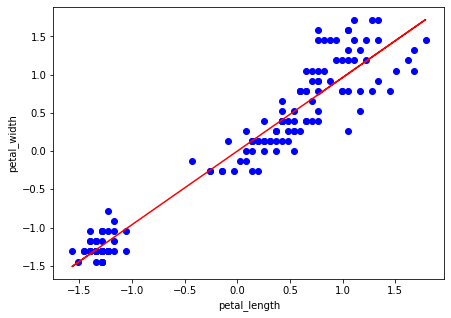

In [42]:
w=normal_equation(X_norm, y_norm)
print(w)

lineplot(X_norm, y_norm, w)

## Q3 応用

課題1と課題3で用いた以下のような形式の"SSDSE.csv"ファイルを読み込みます。

```Python
## SSDSE.csvファイル
code, prefecture, municipality, A1101,	A110101, A110102, ..., A4101
地域コード, 都道府県, 市区町村, 人口総数, 人口総数（男）, 人口総数（女）, ..., 出生数
R01100, 北海道, 札幌市, 1952356, 910614, 1041742, ..., 14021
R01202, 北海道, 函館市, 265979, 120376, 145603, ..., 1532
R01203, 北海道, 小樽市, 121924, 54985, 66939, ..., 512
...
```

`pandas`モジュールでは、"SSDES.csv"ファイルから以下のようにデータフレーム`df`を作成できます。この時、csvファイルの2行目（日本語ヘッダ）は`skiprows=[1]`で読み飛ばしています。
```Python
df = pd.read_csv('SSDSE.csv',  skiprows=[1])
```

東京都の市区町村の人口総数（A1101）と出生数（A4101）の関係を散布図で可視化すると以下のように2つの統計に関係があることがわかります。

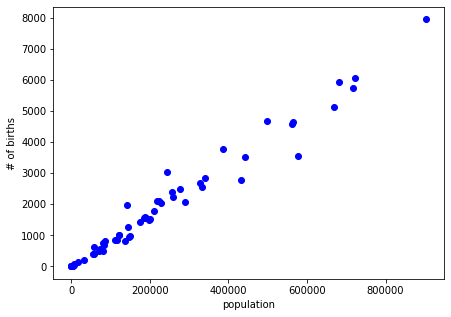

In [43]:
df = pd.read_csv('SSDSE.csv', skiprows=[1])
df=df[df['prefecture']=='東京都']
plt.figure(figsize=(7,5))
plt.xlabel('population')
plt.ylabel('# of births')
plt.scatter(df['A1101'], df['A4101'], c='blue');

上記のQ1で行った線形回帰のパラメータ推定を参考に、人口総数$x$から出生数$y$を予測するような仮説関数$y=\theta_0+\theta_1x$のパラメータ$\theta_0, \theta_1$を学習し、学習されたパラメータを元に回帰直線を可視化してください。

Text(0, 0.5, '# of births')

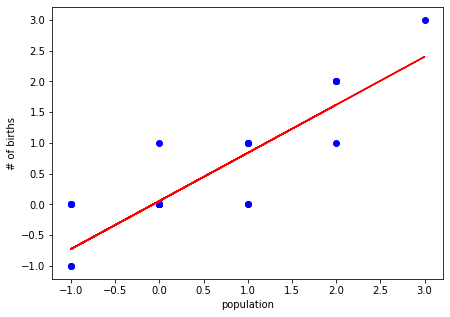

In [52]:
#線形回帰のパラメータは訓練データセットの入力 𝑋と出力 𝑦に対して以下の正規方程式を解くことで解析的に求めることができます。

X=df[['A1101']].values # 入力：人口総数
y=df[['A4101']].values # 出力: 出生数

X_norm = normalizer(X) # 入力の標準化
y_norm = normalizer(y) # 出力の標準化

X_norm=np.insert(X_norm, 0, np.ones((1,X.shape[0]), dtype=int), axis=1) # バイアス項の追加

costs, w = graddes(X_norm, y_norm, alpha=1, n_iter=100)

lineplot(X_norm, y_norm, w)
plt.xlabel('population')
plt.ylabel('# of births')
###  線形回帰により人口総数から出生数を予測するような仮説関数のパラメータを学習し、学習されたパラメータを元に回帰直線を可視化 ###

## 参考：scikit-learnでの線形回帰
`scikit-learn`では、以下の手順でデータからモデルの学習を行います。
- 使用するモデルのクラスの選択
- モデルのハイパーパラメータの選択とインスタンス化
- データの準備
    - 教師あり学習では、特徴量データとラベルデータを準備
    - 教師あり学習では、特徴量・ラベルデータをモデル学習用の学習データとモデル評価用のテストデータに分ける
- モデルをデータに適合（`fit()`メソッド）
- モデルの評価
    - 教師あり学習では、`predict()`メソッドを用いてテストデータの特徴量データからラベルデータを予測しその精度を評価を行う
    
以下では、回帰を行うモデルの一つである**線形回帰**（**`LinearRegression`**）クラスをインポートしています。`mean_squared_error()`は平均二乗誤差によりモデルの予測精度を評価するための関数です。

データセットを訓練データ（`X_train`, `y_train`）とテストデータ（`X_test`, `y_test`)に分割し、線形回帰クラスのインスタンスの`fit()`メソッドによりモデルを訓練データに適合させています。そして、`predict()`メソッドを用いてテストデータのpetal_lengthの値からpetal_widthの値を予測し、`mean_squared_error()`関数で実際のpetal_widthの値（`y_test`）と比較して予測精度の評価を行なっています。

0.0885152235812096
[[0.96858954]]
[4.13011075e-16]


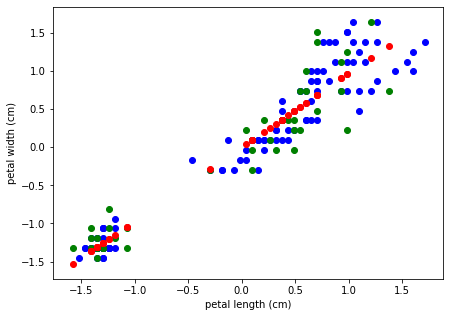

In [53]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

iris = load_iris() 
X=(iris['data'][:,2])[:,np.newaxis] 
y=(iris['data'][:,3])[:,np.newaxis] 

# 訓練データとテストデータ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 標準化
sc=StandardScaler() 
sc.fit(X_train)
norm_X_train=sc.transform(X_train) 
norm_X_test=sc.transform(X_test) 

sc.fit(y_train)
norm_y_train=sc.transform(y_train) 
norm_y_test=sc.transform(y_test) 

# 自分でバイアス項追加する場合 
# LinearRegression()ではデフォルトでバイアス項が作られる（fit_intercept引数=True）
#norm_X_train=np.insert(norm_X_train, 0, np.ones((norm_X_train.shape[0],1), dtype=int).T, axis =1)
#norm_X_test=np.insert(norm_X_test, 0, np.ones((norm_X_test.shape[0],1), dtype=int).T, axis =1)

# 学習モデルの訓練データへの適合
model=LinearRegression() 
model.fit(norm_X_train, norm_y_train) 

# 学習モデルを用いてテストデータから予測と評価
y_predicted=model.predict(norm_X_test) 
print(mean_squared_error(norm_y_test,y_predicted))

print(model.coef_)
print(model.intercept_)

plt.figure(figsize=(7,5))
plt.xlabel(iris["feature_names"][2])
plt.ylabel(iris["feature_names"][3])
plt.scatter(norm_X_train[:,0], norm_y_train[:,0],c='blue') # 訓練データ
plt.scatter(norm_X_test[:,0], norm_y_test[:,0], c='green'); # テストデータ
plt.scatter(norm_X_test[:,0], y_predicted[:,0], c='red'); # テストデータの予測